In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [2]:
#importing data
hour_df = pd.read_csv("hour.csv")
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


# data preprocessing

In [3]:
# Renaming columns names to more readable names
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

###########################
# Setting proper data types
###########################
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

# plotting

In [4]:
# Configuring plotting visual and sizes
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

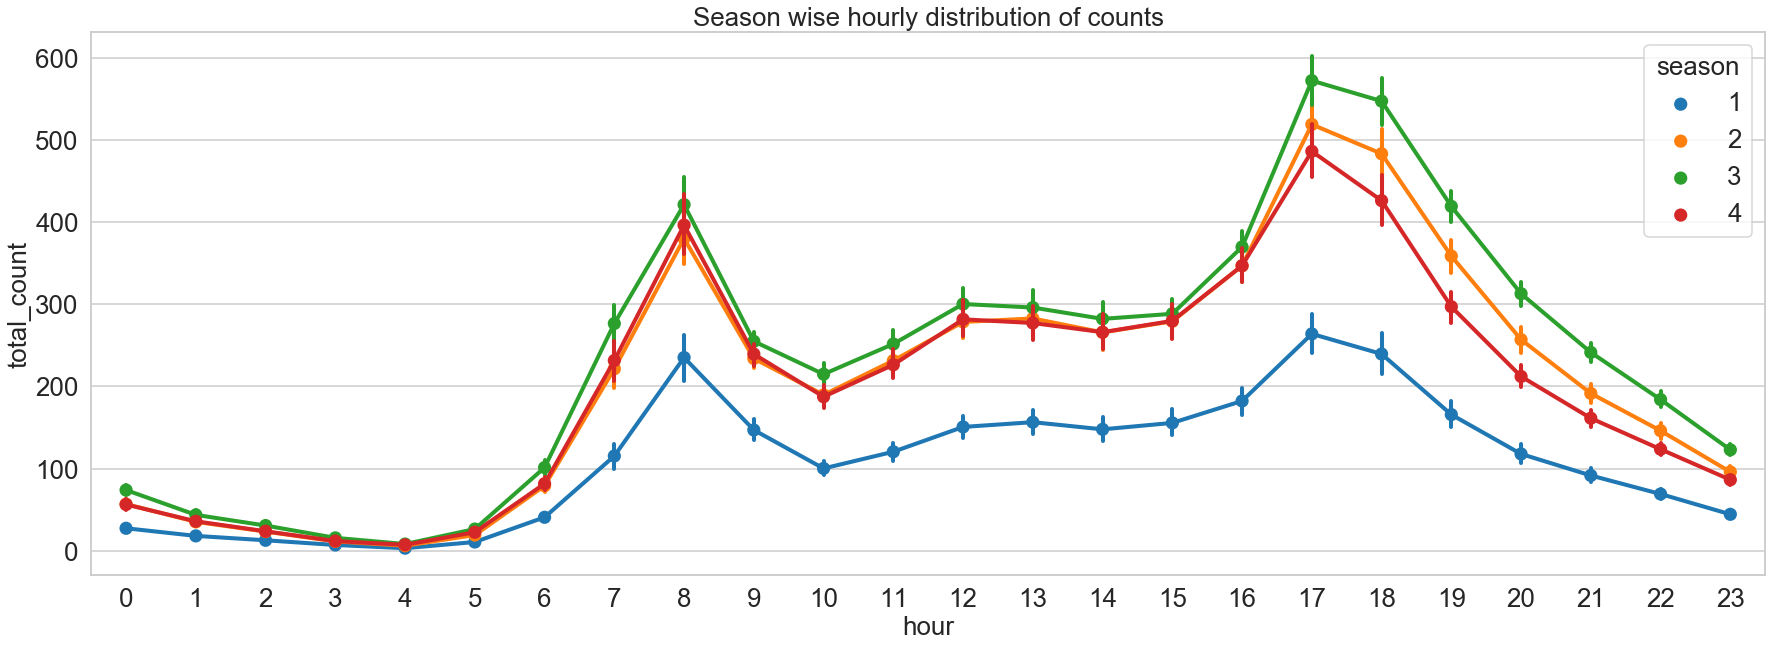

In [5]:
fig,ax = plt.subplots()
sns.pointplot(data=hour_df[['hour',
                           'total_count',
                           'season']],
              x='hour',
              y='total_count',
              hue='season',
              ax=ax)
ax.set(title="Season wise hourly distribution of counts")

[Text(0.5, 1.0, 'Weekday wise hourly distribution of counts')]

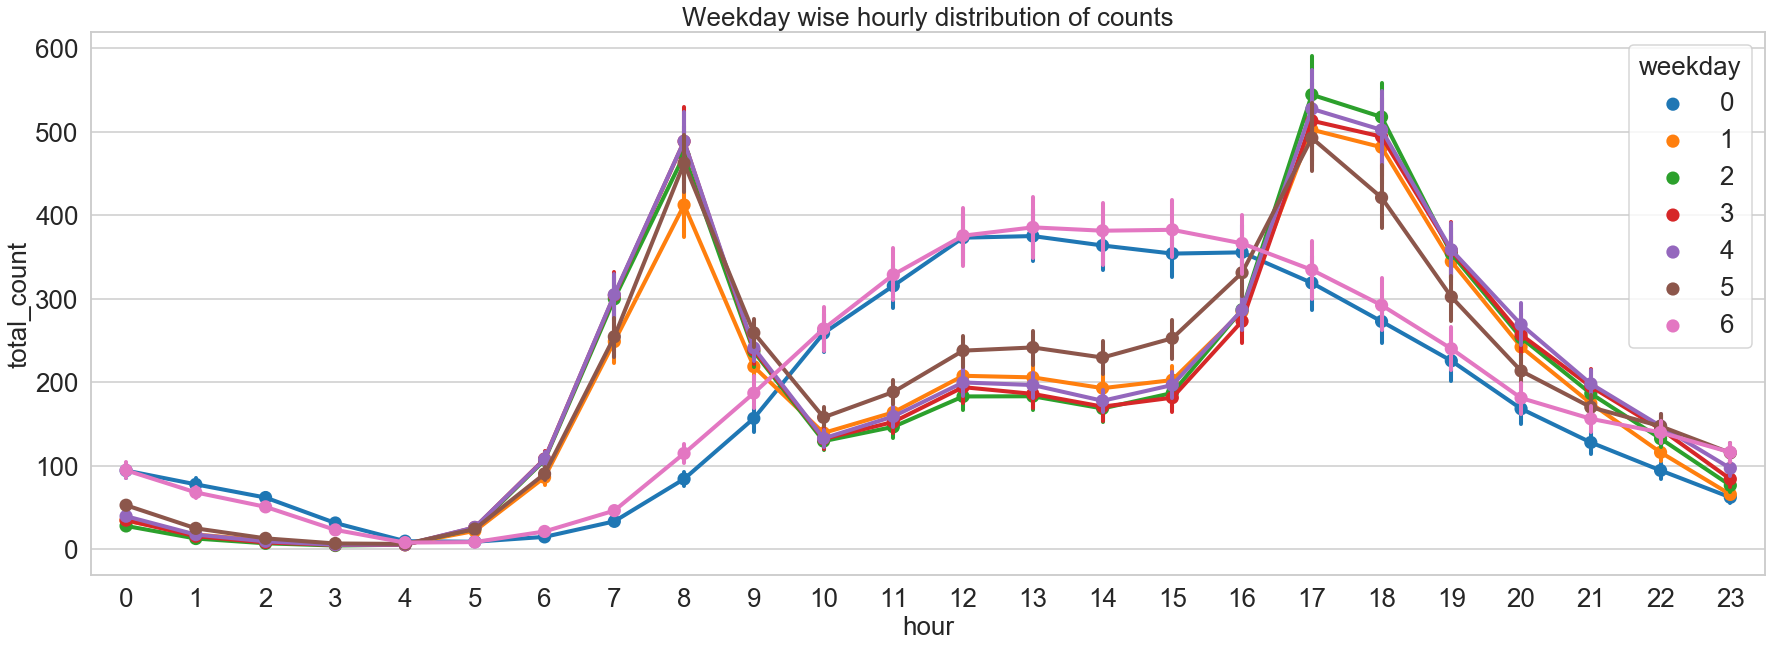

In [7]:
fig,ax = plt.subplots()
sns.pointplot(data=hour_df[['hour',
                           'total_count',
                           'weekday']],
              x='hour',
              y='total_count',
              hue='weekday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of counts")

[Text(0.5, 1.0, 'Monthly distribution of counts')]

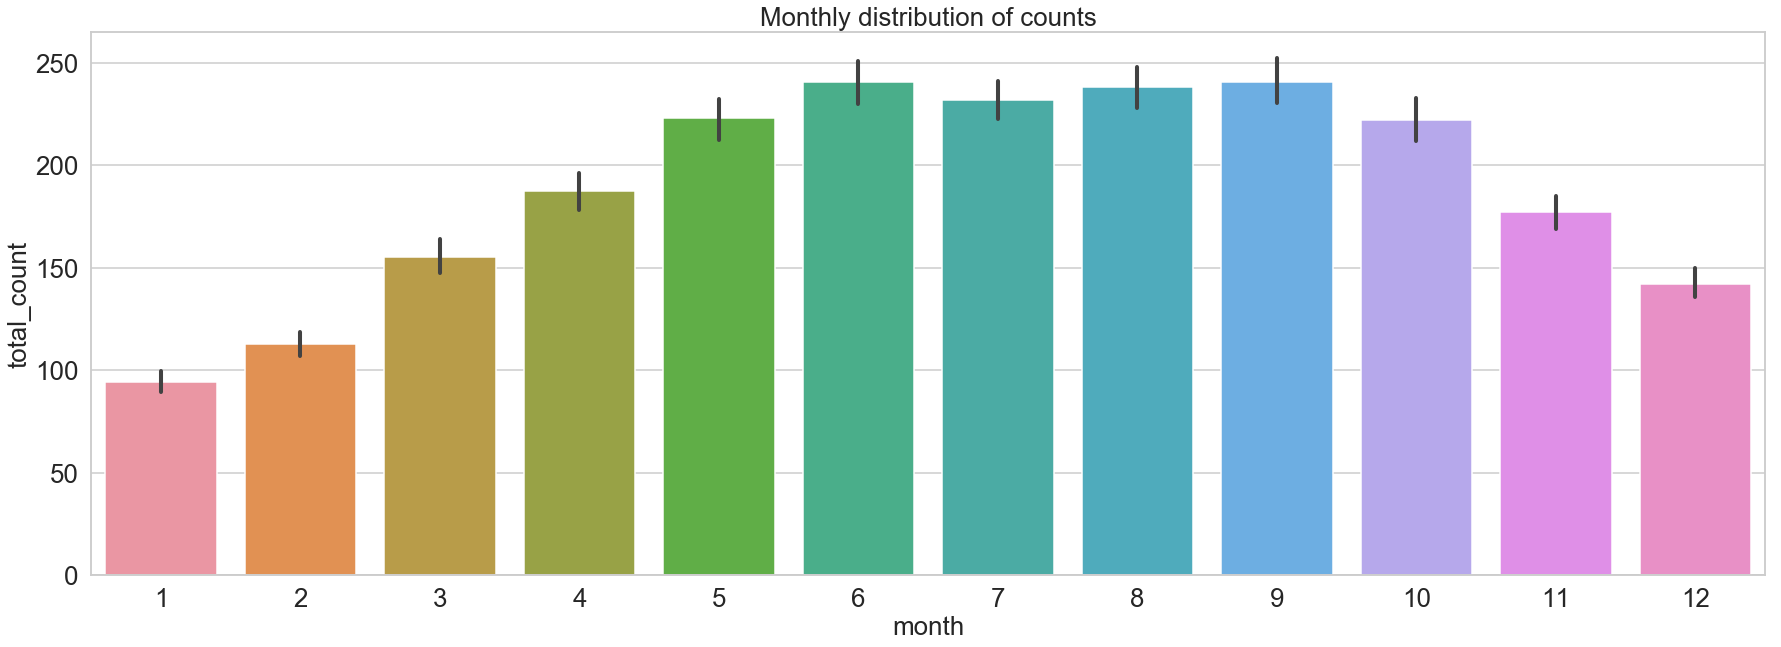

In [8]:
fig,ax = plt.subplots()
sns.barplot(data=hour_df[['month',
                           'total_count']],
              x='month',
              y='total_count',
              ax=ax)
ax.set(title="Monthly distribution of counts")

[Text(0.5, 1.0, 'Seasonal distribution of counts')]

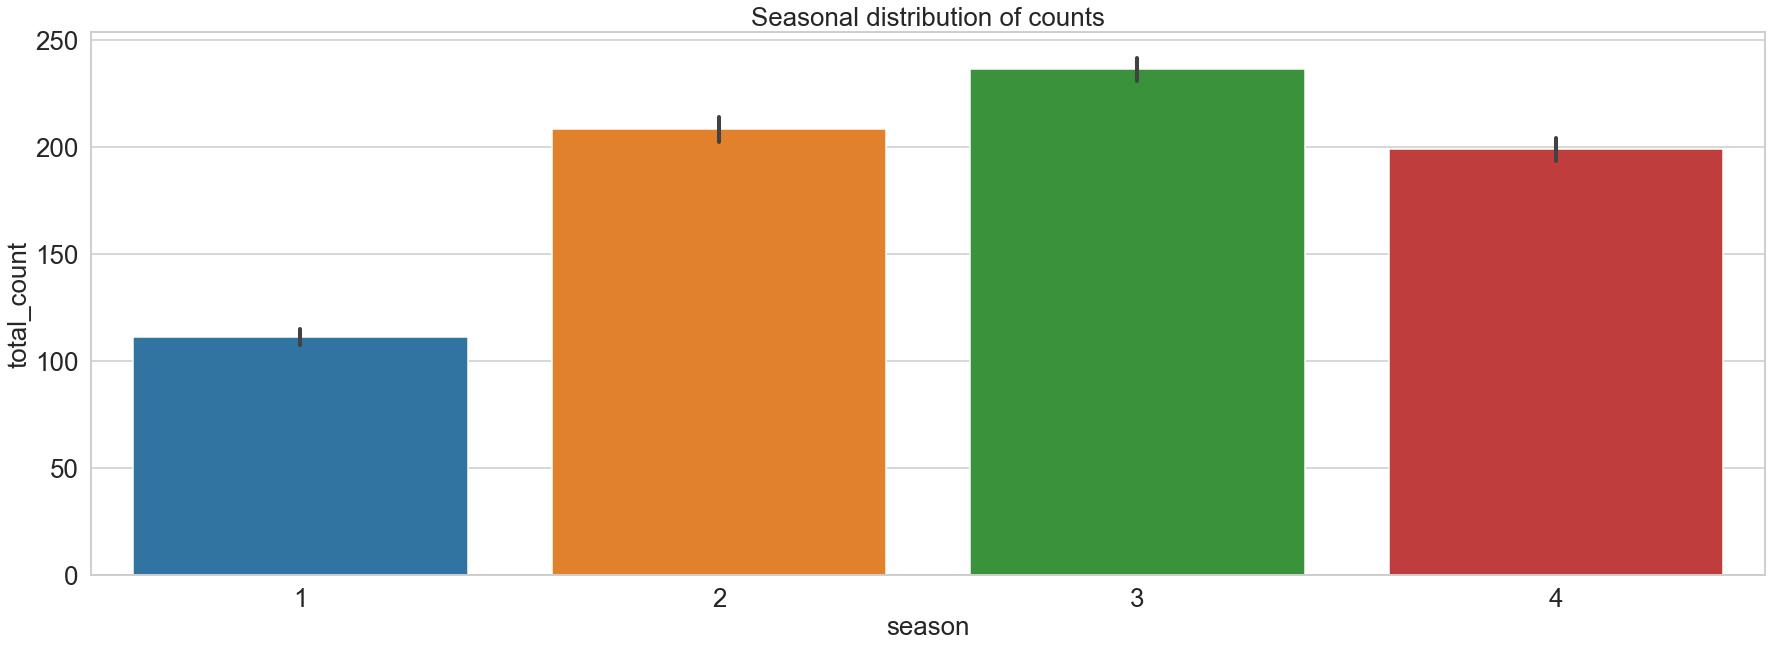

In [9]:
fig,ax = plt.subplots()
sns.barplot(data=hour_df[['season',
                           'total_count']],
              x='season',
              y='total_count',
              ax=ax)
ax.set(title="Seasonal distribution of counts")

[Text(0.5, 1.0, 'Year distribution of counts')]

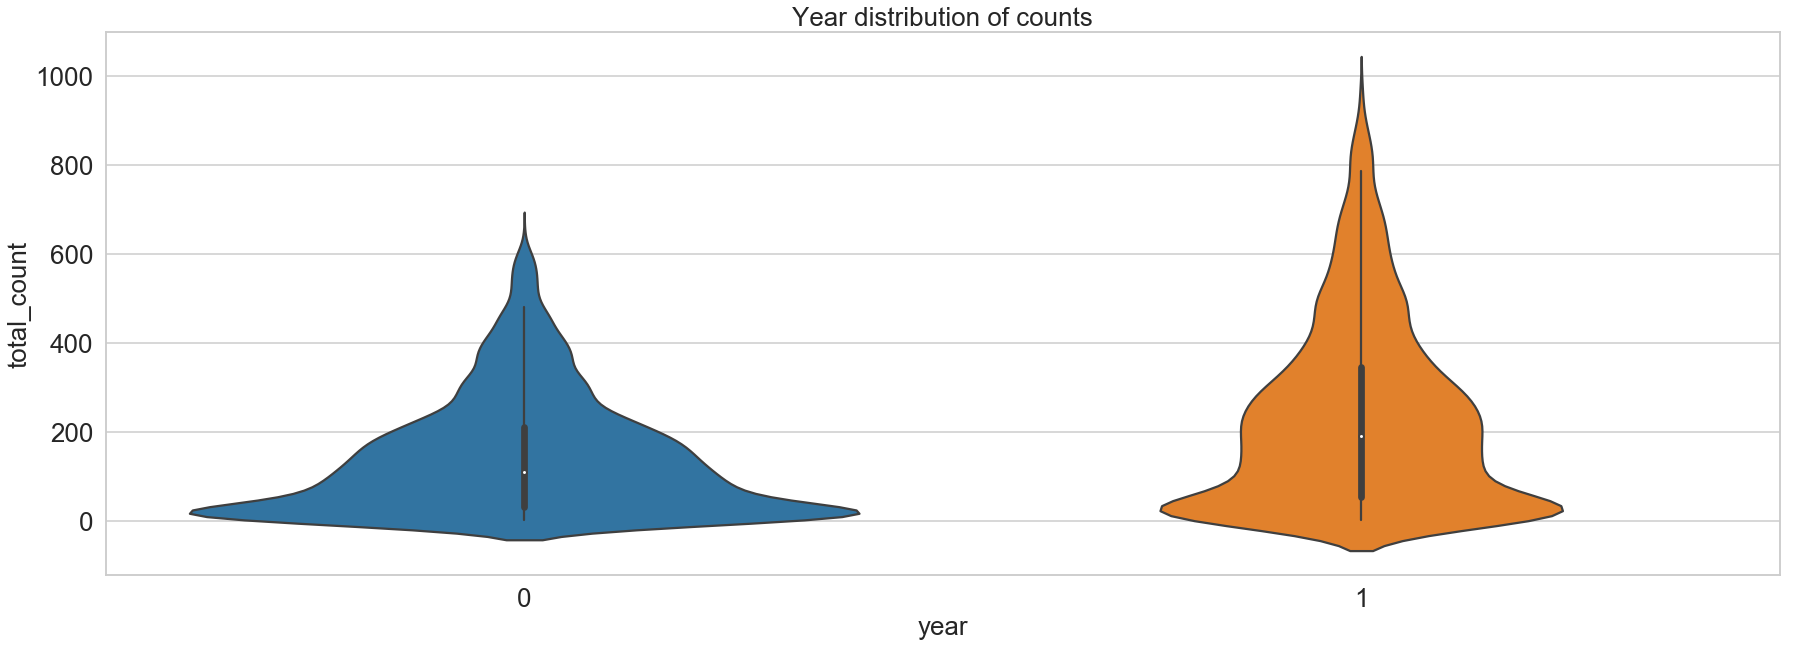

In [10]:
fig,ax = plt.subplots()
sns.violinplot(data=hour_df[['year',
                           'total_count']],
              x='year',
              y='total_count',
              ax=ax)
ax.set(title="Year distribution of counts")

# Memeriksa outliners

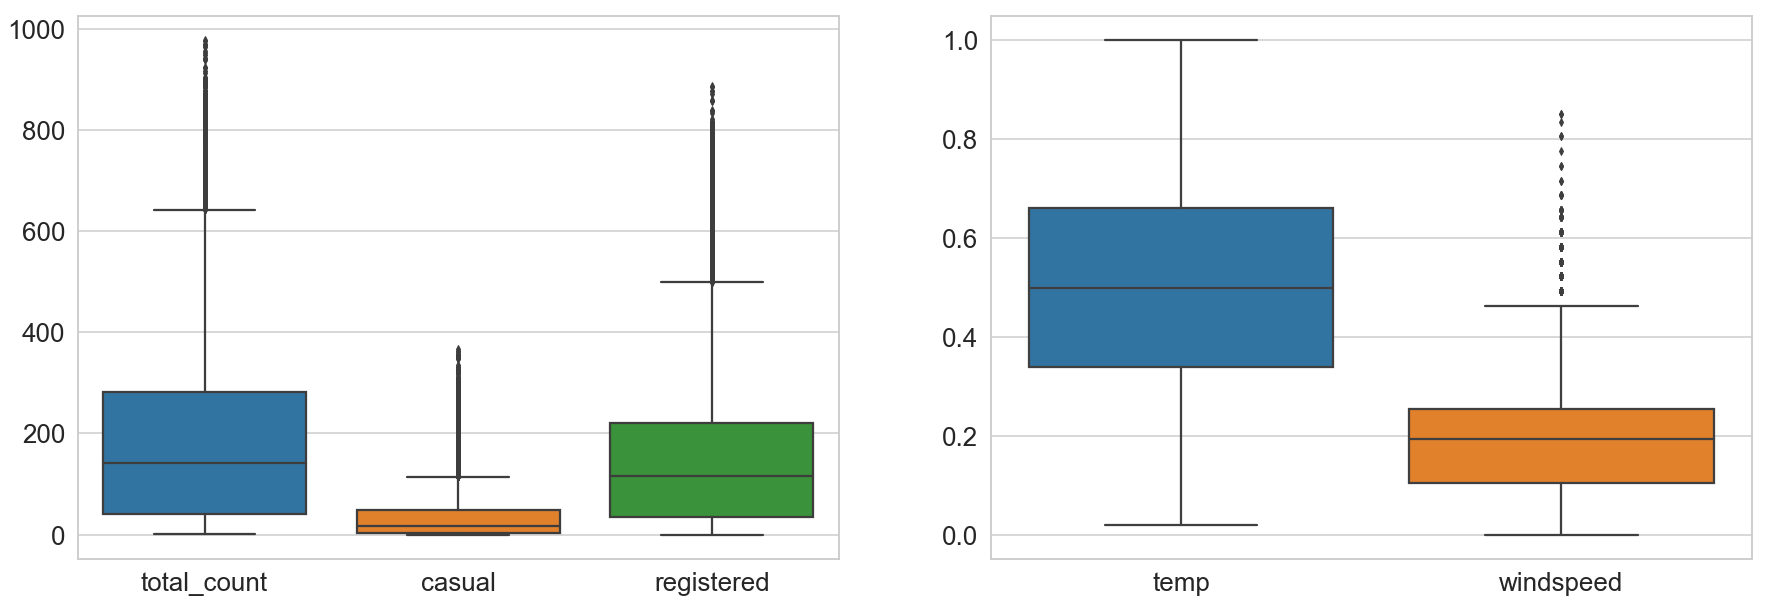

In [11]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
sns.boxplot(data=hour_df[['total_count',
                          'casual',
                          'registered']],ax=ax1)
sns.boxplot(data=hour_df[['temp',
                          'windspeed']],ax=ax2)

[Text(0.5, 1.0, 'Checking for outliners in day hours')]

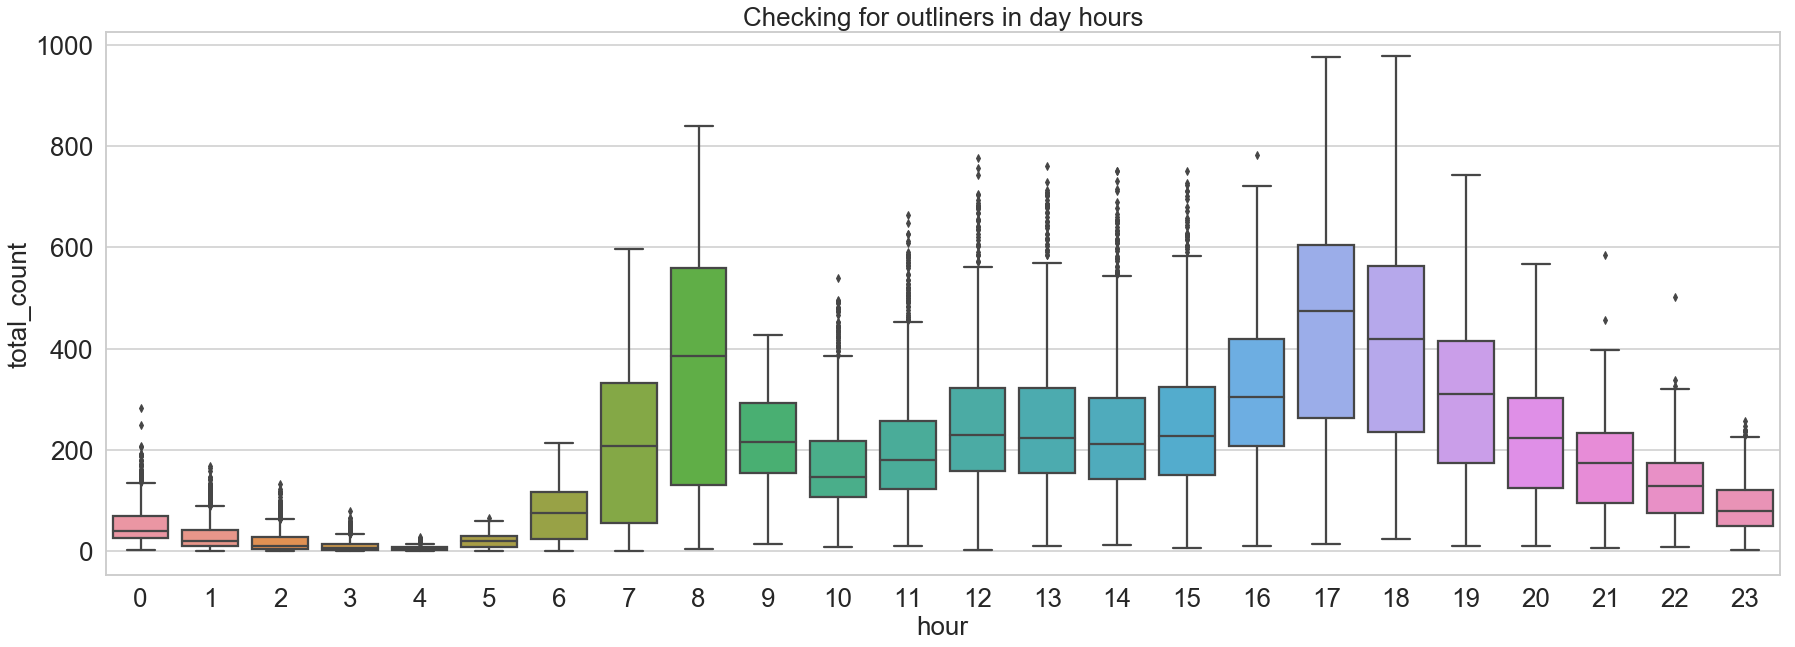

In [12]:
fig,ax = plt.subplots()
sns.boxplot(data=hour_df[['total_count',
                          'hour']],x='hour',y='total_count',ax=ax)
ax.set(title="Checking for outliners in day hours")

# melihat korelasi

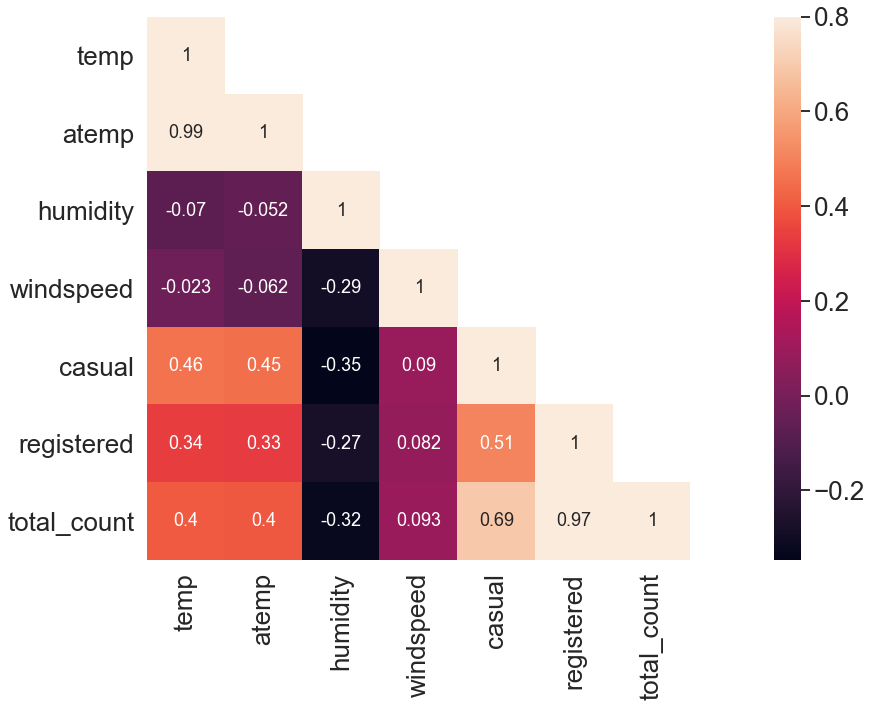

In [13]:
corrMatt = hour_df[['temp',
                    'atemp', 
                    'humidity', 
                    'windspeed', 
                    'casual', 
                    'registered', 
                    'total_count']].corr()

mask = np.array(corrMatt)
# Turning the lower-triangle of the array to false
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
sns.heatmap(corrMatt, 
            mask=mask,
            vmax=.8, 
            square=True,
            annot=True,
            ax=ax)

# feature engineering

In [14]:
# Defining categorical variables encoder method
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

# membagi data set menjadi data training and data testing

In [15]:
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3],
                                        hour_df.iloc[:,-1],
                                        test_size=0.33,
                                        random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [16]:
# Encoding all the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp','humidity','windspeed',
                        'hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

###############
# Train dataset
###############
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})


feature_df_list  = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Train dataset shape::{}".format(train_df_new.shape))
print(train_df_new.head())

##############
# Test dataset
##############
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Test dataset shape::{}".format(test_df_new.shape))
print(test_df_new.head())

C:\Users\Taufan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Taufan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you 

Train dataset shape::(11643, 19)
   temp  humidity  windspeed hour weekday month year  season_1  season_2  \
0  0.64      0.65     0.1940    0       5     9    0       0.0       0.0   
1  0.50      0.45     0.2239   13       2     3    0       0.0       1.0   
2  0.86      0.47     0.5224   12       0     8    1       0.0       0.0   
3  0.30      0.61     0.0000    2       3     2    1       1.0       0.0   
4  0.54      0.19     0.4179   17       6     4    1       0.0       1.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       1.0       0.0           1.0           0.0                  1.0   
1       0.0       0.0           1.0           0.0                  1.0   
2       1.0       0.0           1.0           0.0                  1.0   
3       0.0       0.0           1.0           0.0                  1.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  weather_condition_4 

C:\Users\Taufan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Taufan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you 

# Modeling

In [17]:
X = train_df_new
y = y.total_count.values.reshape(-1,1)

lin_reg = linear_model.LinearRegression()

# using the k-fold cross validation (specifically 10-fold) to reduce overfitting affects
# cross_val_predict function returns cross validated prediction values as fitted by the model object.
predicted = cross_val_predict(lin_reg, X, y, cv=10)

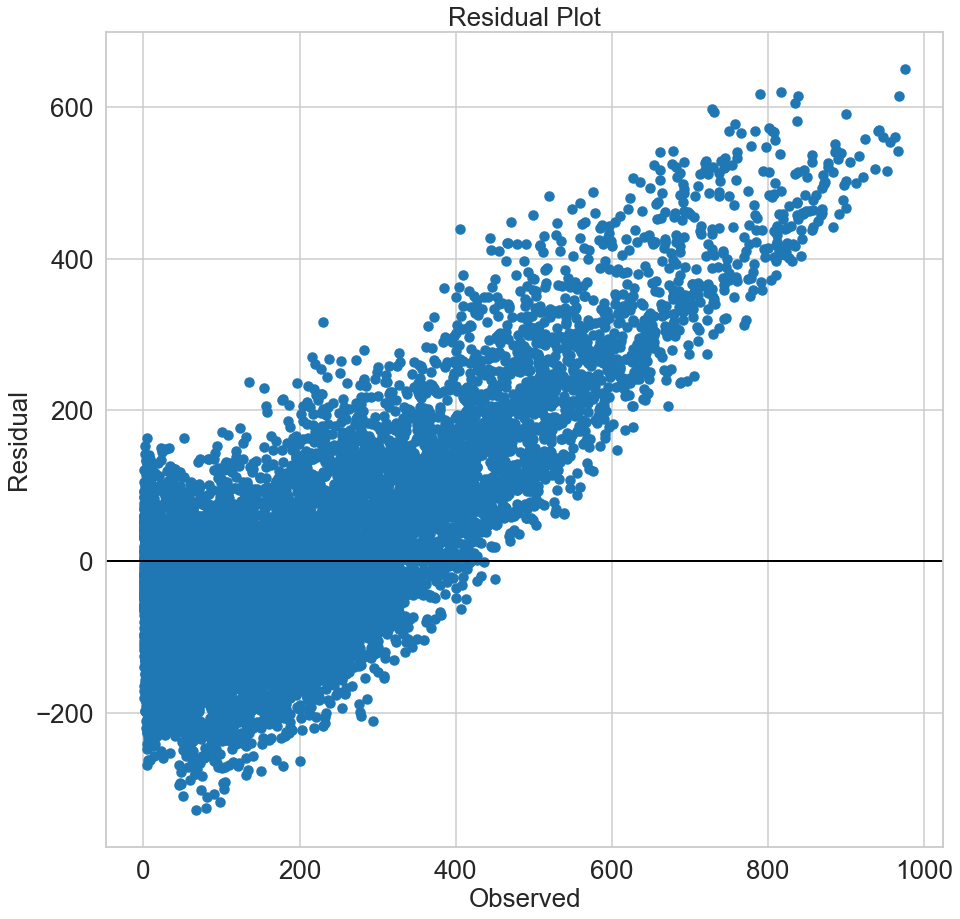

In [19]:
# Analysing residuals in our predictinos
fig,ax = plt.subplots(figsize=(15,15))
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
ax.set_title('Residual Plot')
plt.show()

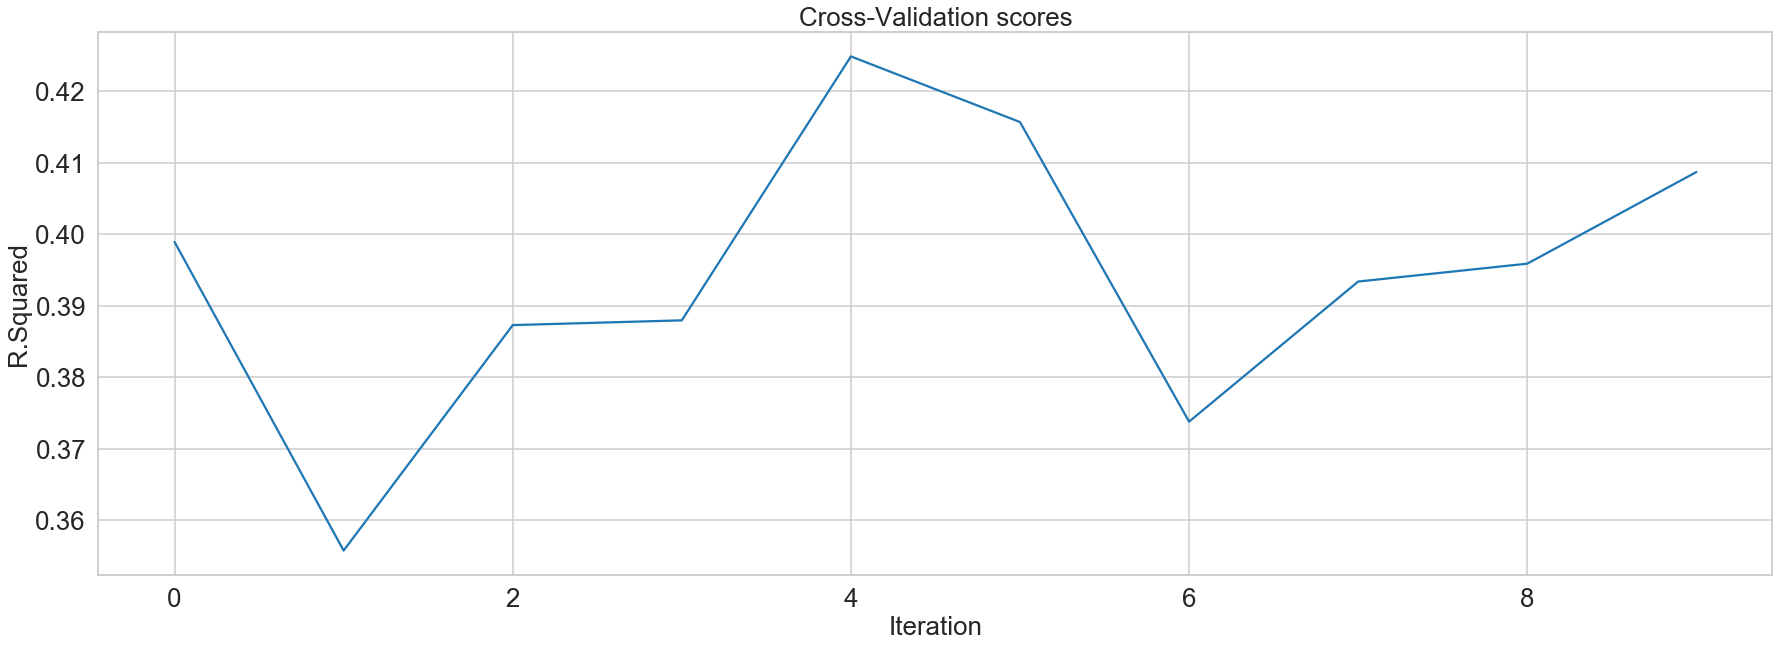

R-squared::[0.39894459 0.35575732 0.3873037  0.38796861 0.42489499 0.41571164
 0.37379762 0.39339864 0.39589746 0.40871611]
MSE::[-19612.38349313 -20800.77110185 -20256.54013607 -18545.99033804
 -18746.57816436 -21015.35560028 -21549.12876053 -21567.27946203
 -21044.42416385 -18899.05989574]


In [20]:
# Evaluating model in cross-validation iteration

r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')

fig,ax = plt.subplots()
ax.plot(range(0,10),
        r2_scores)
ax.set_xlabel('Iteration')
ax.set_ylabel('R.Squared')
ax.set_title('Cross-Validation scores')
plt.show()


print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse))

# Testing dataset dan evaluation

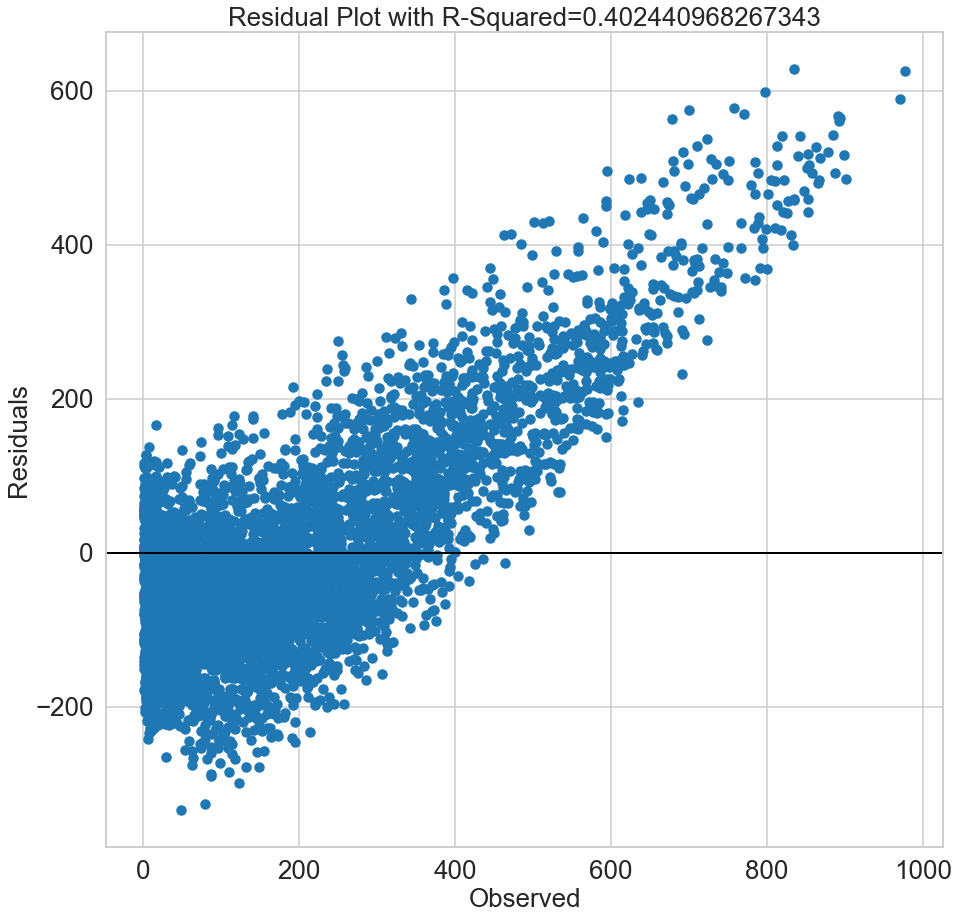

MSE: 19062.999756009267


In [21]:
# Predict model based on training dataset
lin_reg.fit(X,y)

# Constructing test dataset
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)


y_pred = lin_reg.predict(X_test)
residuals = y_test-y_pred

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(lin_reg.score(X_test,y_test))))
plt.show()

print("MSE: {}".format(metrics.mean_squared_error(y_test, y_pred)))

Seperti yang kita lihat, hanya dapat memprediksi sekitar 40% dari hasil. hal ini disebabkan karena non-linearitas variabel independen terhadap fitur dependen.